# Prediction error, cross-validation, and significance testing

In the previous notebook we showed a few different models. We should have a way to evaluate our models and possibly  to choose the best one. 

Let's explore the topic of model validation and understanding various errors for regression models. We will start from creating a new dataset:

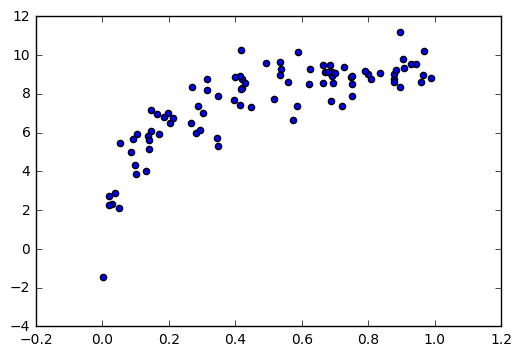

In [186]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def make_data(N=90, error=1.0, random_seed=None):
    def test_func(x, err=0.5):
        y = 10 - 1. / (x + 0.1)
        if err > 0:
            y = np.random.normal(y, err)
        return y

    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

X, y = make_data(random_seed=1)
plt.scatter(X.ravel(), y)

Let's divide this time our data for two sets that we will call training and test, and build a simple linear regression model using training data only:

In [187]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's plot the results. We will also calculate the model score. The score is a funcion of mean square error, but defined in a way that gives 1 (or -1) for the best possible model and 0 if there is no linear relation, full definition you can find [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) 

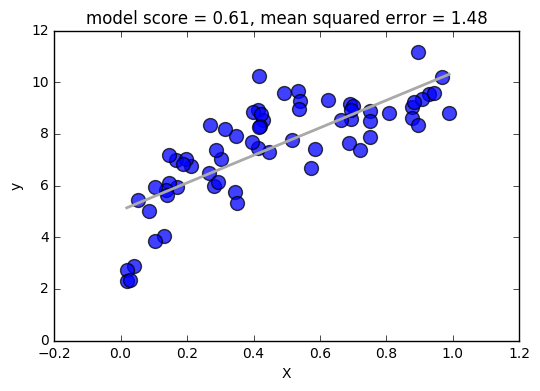

In [221]:
from sklearn.metrics import mean_squared_error

def plot_regr(X, y, model, color="b"):
    fig, ax = plt.subplots()
    
    X_plot = np.linspace(X[:,0].min(), X[:,0].max(), 100)[:, np.newaxis]
    y_plot = model.predict(X_plot)
    ax.plot(X_plot, y_plot, color='darkgrey', linewidth=2)
    ax.scatter(X[:,0], y, s=100, alpha=0.75, c=color)
    
    y_pr = model.predict(X)
    mse = mean_squared_error(y, y_pr)
    
    ax.set_title("model score = {:03.2f}, mean squared error = {:4.2f}".format(model.score(X,y), mse))
    ax.set_xlabel('X')
    ax.set_ylabel('y')

plot_regr(X_train, y_train, regr)

As you can see, our model is not doing a great job and we might want to try more complex model, e.g. including polynomial terms. We will create our ``PolynomialRegression`` using scikit-learn [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) and [make_pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html).

In [222]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

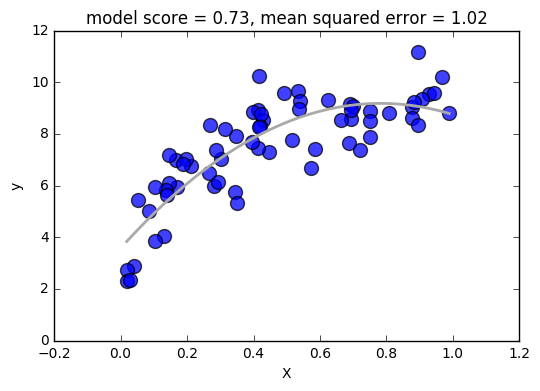

In [223]:
poly2 = PolynomialRegression(2)
poly2.fit(X_train, y_train)
plot_regr(X_train, y_train, poly2)

This is much better, so we might try to go to even higher polynomials.

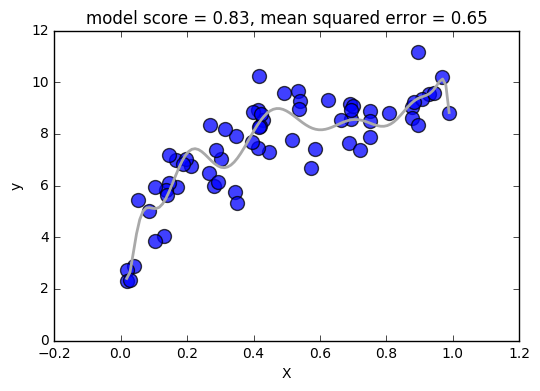

In [224]:
poly15 = PolynomialRegression(15)
poly15.fit(X_train, y_train)
plot_regr(X_train, y_train, poly15)

That seems to be even better fit to our data. But at the end we shouldn't care about the score for training data. We want our model to predict a good responses for new data! Now, it's the time to use our test dataset that we did not use to build our model.

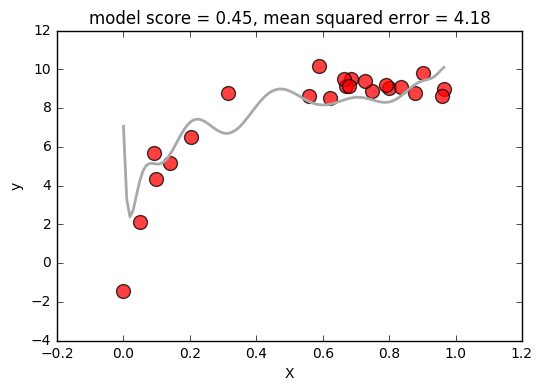

In [225]:
plot_regr(X_test, y_test, poly15, color="r")

Now we can see that for the test set the model doesn't look so great and the score is not impressive. It is actually lower than for the first linear model we built:

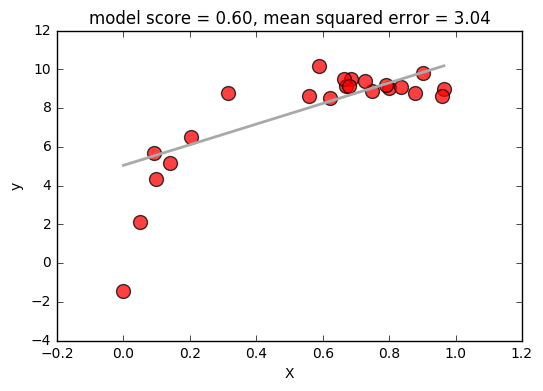

In [226]:
plot_regr(X_test, y_test, regr, color="r")

The best results we have for poly2:

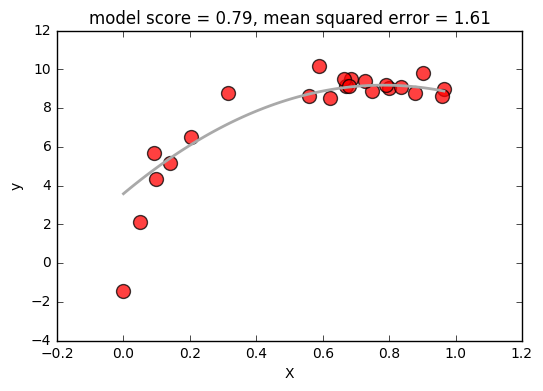

In [227]:
plot_regr(X_test, y_test, poly2, color="r")

The problem is related to the [**bias–variance tradeoff**](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). The **bias** is error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs and it's also called **underfitting**. The **variance** is error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs and it's also called **overfitting**.

In order to evaluate models **prediction error** is used. Expected prediction error can be written:

\begin{aligned}{\mathrm  {E}}{\Big [}{\big (}y-{\hat  {f}}(x){\big )}^{2}{\Big ]}&={\mathrm  {Bias}}{\big [}{\hat  {f}}(x){\big ]}^{2}+{\mathrm  {Var}}{\big [}{\hat  {f}}(x){\big ]}+\sigma ^{2}\\\end{aligned}
where bias:

\begin{aligned}\mathrm {Bias} {\big [}{\hat {f}}(x){\big ]}=\mathrm {E} {\big [}{\hat {f}}(x)-f(x){\big ]}\end{aligned}

and variance:

\begin{aligned}\mathrm {Var} {\big [}{\hat {f}}(x){\big ]}=\mathrm {E} [{\hat {f}}(x)^{2}]-\mathrm {E} [{\hat {f}}(x)]^{2}\end{aligned}

and $\sigma^2$ is irreducible error.

All terms are positive and in order to minimize the value we have to minimize bias and/or variance. When we are increasing complexity of the model we're decreasing bias, but increasing variance, so we should always try to find optimal solution, that is schematically presented in the figure:

<img src="../img/bias_var_modcomplex.png", width=500>


Another way of thinking about it can be thinking about training error vs predicted/test error. When we are building more complex model we are decreasing training error but the difference between test and training error at some point starts increasing faster. 

<img src="../img/error_complexity.png", width=500>


## Cross validation

Now we know why we divided our dataset to training and testing sets. It's critical to validate a suprvised model using using data that was NOT used during training!
Unfortunately, the simplest splitting we used in our example has a serious drawback, a bid part of our data is not used to build  a better model. If you have a large dataset it might not a problem, but often in neuroscientific studies this is not the case.

However, there are smarter ways of splitting the data and we will show some popular types of so called [**cross validation**](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) (all figures taken from [this post](http://www.ebc.cat/2017/01/31/cross-validation-strategies/)):

In the simples split you train a model once using a part of the dataset

<img src="../img/holdout.png", width=500>

**Leave-p-out cross-validation (LpO CV)**

Leave-p-out cross-validation involves using p observations as the validation set and the remaining observations as the training set. This is an exhaustive method, so all possible combinations of p samples must be used.
This requires training and validating the model $C_{p}^{n}$  times, where $C_{p}^{n}$ is a binomial coefficient, $n$ is the number of observations in the original sample, for even moderately large n, LpO CV can become computationally infeasible (e.g. $C_{30}^{100}\approx 3\times 10^{25}$). 

<img src="../img/leave_p_out.png", width=500>

**Leave-one-out cross-validation (LOO CV)**

Leave-one-out cross-validation is a special case of leave-p-out cross-validation with $p = 1$. LOO cross-validation does not have the same problem of excessive compute time, since $C_{1}^{n}=n$.

<img src="../img/leave_one_out.png", width=500>

**K-fold**

There are also non-exhaustive cross validation methods, that don't require computing all ways of splitting the original sample. Those methods are approximations of leave-p-out cross-validation.
In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. A single subsample is retained as the validation data, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times. The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once.

<img src="../img/kfold.png", width=500>

**Random subsamples (without replacement)**

This method is similar to k-fold strategy, but in each iteration we randomly select some samples for testing, and some others for training. An advantage over k-fold is that we can freely decide the number of iterations and the length of each train-test. A drawback of this method is that the samples may never be selected in the test set, whereas others may be selected more than once:

<img src="../img/random_subsampling.png", width=500>

In scikit-learn there are [special methods for cross validation](http://scikit-learn.org/stable/modules/cross_validation.html). We will run ``coss_val_score`` for our previously defined models:

In [93]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(regr, X, y)
print("Scores for regr: {}, mean score = {:03.2f}, std = {:03.2f}".format(scores, scores.mean(), scores.std()))
scores = cross_val_score(poly2, X, y)
print("Scores for poly2: {}, mean score = {:03.2f}, std = {:03.2f}".format(scores, scores.mean(), scores.std()))
scores = cross_val_score(poly15, X, y)
print("Scores for poly16: {}, mean score = {:03.2f}, std = {:03.2f}".format(scores, scores.mean(), scores.std()))

Scores for regr: [ 0.55280768  0.62096582  0.62899577], mean score = 0.60, std = 0.07
Scores for poly2: [ 0.74106042  0.7598275   0.69354111], mean score = 0.73, std = 0.06
Scores for poly16: [ 0.63291862 -3.4629217   0.69988795], mean score = -0.71, std = 3.89


As you see the scores has 3 numbers, this is because we used default CV method, that is ``KFold`` for k=3.

## Exercise 4

Using ``make_data`` function generate a new dataset with different sample size. Calculate cross validation score using one od the [splitter methods available in scikit-learn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection). See how the scores differ with the sample size.

## Error metrics for classification

In order to validate binary classification models we are using **error matrix** (or confusion matrix): 
    
<img src="../img/sensit_specif.png", width=500>

The error matric describes four possible scenarios. Since the true response is either Positive or Negative (or 1/0) and model prediction can also have these two value for every sample. That gives us for possibilities:
 - **True Positive (TP)**: model correctly identifies Positive cases, e.g. correctly classifies people with malignant cancer
 - ** False Positive (FP)**:  model incorrectly identifies Positive cases, e.g. predict malignant cancer for people with benign cancer
 - **True Negative (TN)**: model correctly identifies Negative cases, e.g. correctly classifies people with benign cancer
 - **False Negative (FN)**: model incorrectly identifies Negative cases, e.g. predict benign cancer for people with malignant cancer
 
Of course, we would like to have only True Positives and True Negatives, but we often want to have one value to optimize, from error matrix we can calculate following rates:

 - **Precision**: $\frac{TP}{TP + FP}$
 - **Recall**: $\frac{TP}{TP + FN}$
 - **Sensitivity**: $\frac{TP}{TP + FN}$
 - **Specificity**: $\frac{TN}{TN + FP}$ 
 
Ther is always trade-off between Precision and Recall or Sensitivity and Specificity. Sometimes additional scores are defined:

**F score**: $\frac{Precision * Recall}{Precision + Recall}$

Let's calculate values of Precision and Recall for the breast cancer dataset (but splitting data to training and testing sets this time):

In [13]:
from sklearn import datasets
cancer = datasets.load_breast_cancer()

X_can = cancer.data
y_can = cancer.target

X_can_tr, X_can_ts, y_can_tr, y_can_ts = train_test_split(X_can, y_can)

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(X_can_tr[:, :2], y_can_tr)
y_pred = clf.predict(X_can_ts[:, :2])

In [17]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
precision_score(y_can_ts, y_pred), recall_score(y_can_ts, y_pred)

(0.87878787878787878, 0.97752808988764039)

We diagnosed correctly almost 97% of people with malignant cancer, so it sounds as a pretty nice results. But at the same time 18% of people who were diagnosed with malignant cancer didn't actually have one and they might have mixed feelings...

And what if we take all features into account?

In [15]:
clf_full = KNeighborsClassifier()
clf_full.fit(X_can_tr, y_can_tr)
y_pred = clf_full.predict(X_can_ts)
precision_score(y_can_ts, y_pred), recall_score(y_can_ts, y_pred)

(0.87878787878787878, 0.97752808988764039)

This looks better! We didn't improve recall too much, but we do have much less FP, so our precision is higher.

## Significance testing

When we any of these metrics to evaluate our model we shouldn't think only about the single number. 90 or 95% migh look very good, but it doesn't necessarily mean that our model is doing a great job. Let's imagine situation when we have 100 samples and only 2 of them have cancer. If we build a model that gives always answer NO we will have a great accuracy and even better specificity, but we probably shouldn't  call this a ML algorithm. 

One way of checking if our algorithm is learning and not giving a random or a trivial answer is performing a **significance or permutation test**. The main idea behind the test is checking if our model is sensitive to training labels. In order to check it, we run multiple models (hundreds or thousands) with permuted labels in training set. For every single run we can calculate metric, e.g. accuracy, and create a histogram of our results that should form some distribution. Now we can see how many randomly permuted sets give the original or better score and calculate the P-value. If we see that our score is in the middle of distribution this is a clear sign that our model is useless.  

Scikit-lear have a special method to make this evaluation for you - [permutation_test_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.permutation_test_score.html)

In [19]:
from sklearn.cross_validation import permutation_test_score

In [86]:
clf = KNeighborsClassifier()
score, permutation_scores, pvalue = permutation_test_score(
    clf, X_can, y_can, scoring="accuracy", cv=None, n_permutations=1000, n_jobs=1)
print("Classification score %s (pvalue : %s)" % (score, pvalue))

Classification score 0.922667780563 (pvalue : 0.000999000999001)


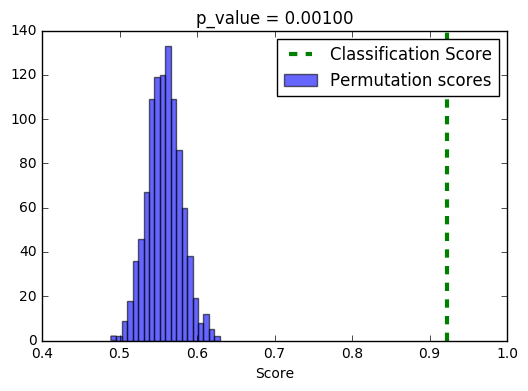

In [87]:
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black', alpha=0.6)
ylim = plt.ylim()

plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score')
plt.title("p_value = {:06.5f}".format(pvalue))
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.show()

### Exercise 5

Change number of neigbors in ``KNeighborsClassifier`` model and run ``permutation_test_score`` again. Try a very large number, e.g. 300, can you explain the result? 

### Exercise 6

Run permutation test score for the model build for Iris data. You can use original data or after PCA.